In [1]:
import gymnasium
print(gymnasium.__version__)

1.0.0


In [1]:
from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# from gym.wrappers import TimeLimit
# from gymnasium.wrappers import TimeLimit
# from stable_baselines3.common.vec_env import SubprocVecEnv  # Import SubprocVecEnv



2024-12-04 13:20:15.397159: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 13:20:15.406810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733343615.418377    6406 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733343615.421487    6406 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 13:20:15.434493: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [3]:
# Custom callback for tracking rewards
class RewardTrackingCallback(BaseCallback):
    def __init__(self, moving_avg_window=100, verbose=0):
        super(RewardTrackingCallback, self).__init__(verbose)
        self.episode_rewards = []
        self.moving_avg_rewards = []
        self.moving_avg_window = moving_avg_window
        self.current_rewards = 0

    def _on_step(self) -> bool:
        self.current_rewards += self.locals["rewards"][-1]
        if self.locals["dones"][-1]:
            self.episode_rewards.append(self.current_rewards)
            moving_avg = (
                np.mean(self.episode_rewards[-self.moving_avg_window:])
                if len(self.episode_rewards) > self.moving_avg_window
                else np.mean(self.episode_rewards)
            )
            self.moving_avg_rewards.append(moving_avg)
            self.current_rewards = 0
        return True

In [4]:
# Plot function using seaborn
def plot_rewards_across_seeds(data, title):
    sns.set(style="whitegrid")
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=data, x="Episode", y="Reward", hue="Algorithm", style="Seed")
    plt.title(title)
    plt.xlabel("Episodes")
    plt.ylabel("Reward")
    plt.legend(title="Algorithm and Seed")
    plt.show()

In [5]:
# Function to train models and log results
def train_and_log(env_name, seeds, total_timesteps):
    results = []
    for seed in seeds:
        random.seed(seed)
        np.random.seed(seed)

        vec_env = DummyVecEnv([lambda: Monitor(gym.make(env_name))])

        # PPO Training
        ppo_model = PPO("MlpPolicy", vec_env, verbose=0, seed=seed, device="cpu")
        ppo_callback = RewardTrackingCallback(verbose=0)
        ppo_model.learn(total_timesteps=total_timesteps, callback=ppo_callback)

        for i, reward in enumerate(ppo_callback.episode_rewards):
            results.append({"Episode": i + 1, "Reward": reward, "Algorithm": "PPO", "Seed": f"Seed {seed}"})

        # TRPO Training
        trpo_model = TRPO("MlpPolicy", vec_env, verbose=0, seed=seed, device="cpu")
        trpo_callback = RewardTrackingCallback(verbose=0)
        trpo_model.learn(total_timesteps=total_timesteps, callback=trpo_callback)

        for i, reward in enumerate(trpo_callback.episode_rewards):
            results.append({"Episode": i + 1, "Reward": reward, "Algorithm": "TRPO", "Seed": f"Seed {seed}"})

        vec_env.close()
        ppoName = "ppo_seed:" 
        ppoName = ppoName + str(seed)
        ppo_model.save(ppoName)

        trpoName = "trpo_seed:" 
        trpoName = trpoName + str(seed)
        trpo_model.save(trpoName)

          # Save models
        ppo_model.save(f"ppo_seed_default_{seed}")
        trpo_model.save(f"trpo_seed_default_{seed}")

    
    return pd.DataFrame(results), ppo_model , trpo_model

In [6]:
# # Function to train models and log results
# def train_and_log(env_name, seeds, total_timesteps):
#     results = []
#     max_episode_steps = 3000  # Set the maximum episode length

#     # Create a function to wrap the environment with the desired settings
#     def make_env(seed):
#         def _init():
#             env = gym.make(env_name)
#             env = gym.wrappers.TimeLimit(env, max_episode_steps=max_episode_steps)
#             env.seed(seed)
#             return Monitor(env)
#         return _init

#     for seed in seeds:
#         random.seed(seed)
#         np.random.seed(seed)

#         # Use SubprocVecEnv for parallel environments
#         vec_env = SubprocVecEnv([make_env(seed) for _ in range(1)])

#         # PPO Training
#         ppo_model = PPO("MlpPolicy", vec_env, verbose=0, seed=seed, device="cpu")
#         ppo_callback = RewardTrackingCallback(verbose=0)
#         ppo_model.learn(total_timesteps=total_timesteps, callback=ppo_callback)

#         for i, reward in enumerate(ppo_callback.episode_rewards):
#             results.append({"Episode": i + 1, "Reward": reward, "Algorithm": "PPO", "Seed": f"Seed {seed}"})

#         # TRPO Training
#         trpo_model = TRPO("MlpPolicy", vec_env, verbose=0, seed=seed, device="cpu")
#         trpo_callback = RewardTrackingCallback(verbose=0)
#         trpo_model.learn(total_timesteps=total_timesteps, callback=trpo_callback)

#         for i, reward in enumerate(trpo_callback.episode_rewards):
#             results.append({"Episode": i + 1, "Reward": reward, "Algorithm": "TRPO", "Seed": f"Seed {seed}"})

#         vec_env.close()

#         # Save models with seed information
#         ppoName = f"ppo_seed_{seed}"
#         trpoName = f"trpo_seed_{seed}"
#         ppo_model.save(ppoName)
#         trpo_model.save(trpoName)

#     return pd.DataFrame(results), ppo_model, trpo_model


In [2]:
# Configuration
env_name = "LunarLander-v3"
seeds = [42, 100, 123, 2024, 999]
total_timesteps = 2500000

In [8]:
# Train models and collect results
print("Training models on different seeds...")
results_df, ppo_model, trpo_model = train_and_log(env_name, seeds, total_timesteps)

Training models on different seeds...


In [9]:
# # Plot results
# plot_rewards_across_seeds(results_df, "Comparison of Rewards Across Seeds for PPO and TRPO")

In [10]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to create separate plots for each algorithm
# def plot_separate(data):
#     sns.set(style="whitegrid")
#     algorithms = data["Algorithm"].unique()
#     seeds = data["Seed"].unique()

#     for algorithm in algorithms:
#         plt.figure(figsize=(14, 8))
#         sns.lineplot(data=data[data["Algorithm"] == algorithm], x="Episode", y="Reward", hue="Seed")
#         plt.title(f"{algorithm} Rewards Across Seeds")
#         plt.xlabel("Episodes")
#         plt.ylabel("Reward")
#         plt.legend(title="Seed")
#         plt.show()

# # Call the function to plot
# plot_separate(results_df)

In [11]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to plot separate graphs with shaded variability
# def plot_shaded_variability_by_algorithm(data):
#     sns.set(style="whitegrid")
#     algorithms = data["Algorithm"].unique()

#     for algorithm in algorithms:
#         plt.figure(figsize=(14, 8))
#         sns.lineplot(
#             data=data[data["Algorithm"] == algorithm],
#             x="Episode",
#             y="Reward",
#             hue="Seed",
#             ci="sd",  # Use standard deviation for shading
#             legend=False  # Remove individual legends for better clarity
#         )
#         plt.title(f"{algorithm}: Reward Variability Across Episodes")
#         plt.xlabel("Episodes")
#         plt.ylabel("Reward")
#         plt.show()

# # Call the function to plot
# plot_shaded_variability_by_algorithm(results_df)


In [12]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Function to plot separate graphs for each algorithm
# def plot_rewards_across_seeds_by_algorithm(data):
#     sns.set(style="whitegrid")
#     algorithms = data["Algorithm"].unique()

#     for algorithm in algorithms:
#         plt.figure(figsize=(14, 8))
#         sns.lineplot(
#             data=data[data["Algorithm"] == algorithm],
#             x="Episode",
#             y="Reward",
#             hue="Seed",
#             estimator=None,  # Plot raw data for each seed
#         )
#         plt.title(f"{algorithm}: Reward Patterns Across Seeds")
#         plt.xlabel("Episodes")
#         plt.ylabel("Reward")
#         plt.legend(title="Seed")
#         plt.grid()
#         plt.show()

# # Call the function to plot
# plot_rewards_across_seeds_by_algorithm(results_df)


In [13]:
results_df.to_pickle('results.pkl')


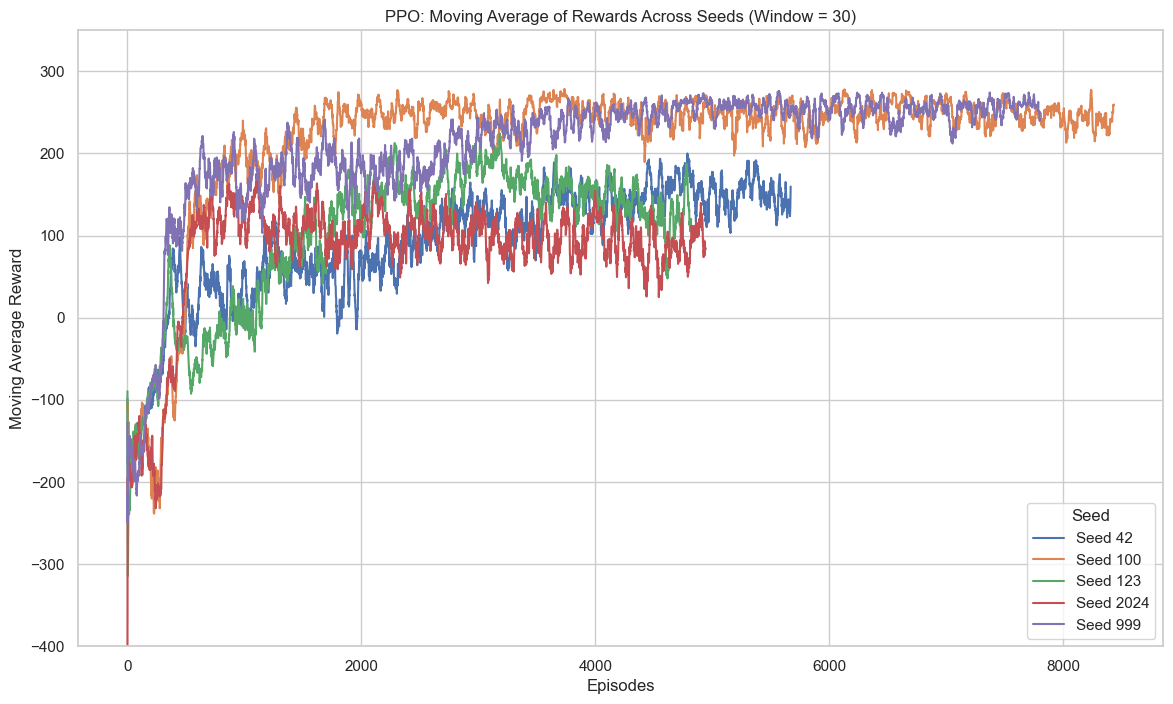

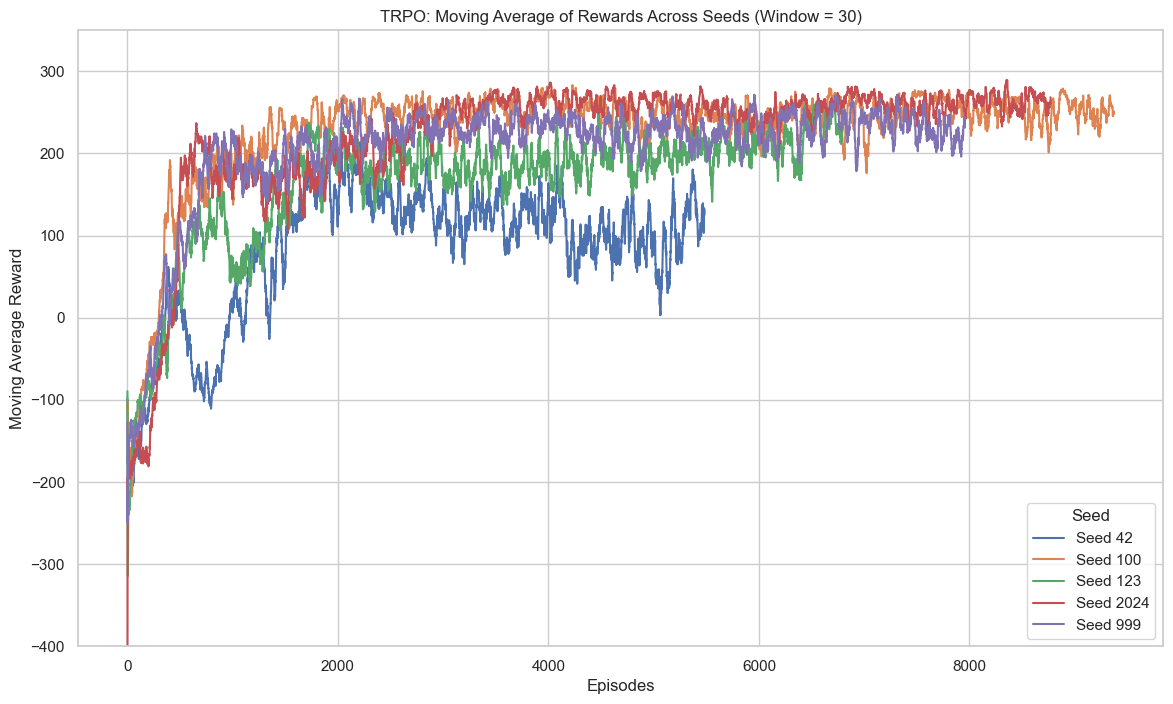

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def compute_moving_average(data, window_size=100):
    data = data.copy()
    data["Moving_Avg"] = (
        data.groupby(["Algorithm", "Seed"])["Reward"]
        .transform(lambda x: x.rolling(window_size, min_periods=1).mean())
    )
    return data

def plot_moving_average_across_seeds(data, window_size=100):
    sns.set(style="whitegrid")
    algorithms = data["Algorithm"].unique()

    for algorithm in algorithms:
        plt.figure(figsize=(14, 8))
        sns.lineplot(
            data=data[data["Algorithm"] == algorithm],
            x="Episode",
            y="Moving_Avg",
            hue="Seed",
            estimator=None  # Plot raw moving averages for each seed
        )
        plt.title(f"{algorithm}: Moving Average of Rewards Across Seeds (Window = {window_size})")
        plt.xlabel("Episodes")
        plt.ylabel("Moving Average Reward")
        plt.ylim(-400, 350)  # Fix y-axis range
        plt.legend(title="Seed")
        plt.grid(True)
        plt.show()

# Configuration
window_size = 30  # Moving average window size

# Compute moving averages
results_with_moving_avg = compute_moving_average(results_df, window_size)

# Plot moving averages with fixed y-axis
plot_moving_average_across_seeds(results_with_moving_avg, window_size)


In [15]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# def plot_mean_reward_with_variance(data):
#     sns.set(style="whitegrid")

#     # Plot mean reward with shaded variance
#     sns.lineplot(
#         data=data,
#         x="Episode",
#         y="Reward",
#         hue="Algorithm",
#         ci="sd",  # Use "sd" for standard deviation or "ci=95" for confidence interval
#     )
#     plt.title("Mean Reward with Variance Across Seeds")
#     plt.xlabel("Episodes")
#     plt.ylabel("Reward")
#     plt.ylim(-400, 250)  # Adjust y-axis as needed
#     plt.legend(title="Algorithm")
#     plt.grid(True)
#     plt.show()

# # Call the function on your results data
# plot_mean_reward_with_variance(results_df)


In [3]:
ppo_model = PPO.load("ppo_seed:42")


/home/pranaypalem/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [10]:
# Rendering the environment for PPO agent
print("Rendering PPO agent in the environment...")
render_env = gym.make(env_name, render_mode = 'human')
obs, info = render_env.reset(seed=42)  # Adjust for gymnasium API
for _ in range(1000000):
    action, _ = ppo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = render_env.step(action)
    render_env.render()  # No mode argument required
    if done or truncated:
        break
render_env.close()

Rendering PPO agent in the environment...


In [18]:
trpo_model = TRPO.load("trpo_seed:999")

/home/pranaypalem/.local/lib/python3.10/site-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run TRPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


In [19]:
# Rendering the environment for TRPO agent
print("Rendering TRPO agent in the environment...")
render_env = gym.make(env_name, render_mode = 'human')
obs, info = render_env.reset(seed=999)  # Adjust for gymnasium API
for _ in range(10000):
    action, _ = trpo_model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = render_env.step(action)
    render_env.render()  # No mode argument required
    if done or truncated:
        break
render_env.close()

# vec_env.close()

Rendering TRPO agent in the environment...


In [20]:
results_df.to_pickle('outputData.pkl')